# Bike Share Rebalancing Minimizer - Model (Phase 3)

### ACKNOWLEDGEMENTS:

Many thanks to: [Michael Dunn](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points), [derricw](https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas), [david strachan](https://stackoverflow.com/questions/25707750/point-to-line-using-angles-and-haversine-with-3-lat-long-points)

### OBJECTIVES:

The objective of this section of the project is to test the predictive ability of 2 models: linear regression and random forest regression. Each model will be tested with 2 features sets. The first set of features will include: longitude, latitude, and elevation. The second set of features will include: latitude, longitude, elevation, distance from Downsview Airport (the point of highest elevation in Toronto), and distance from Lake Ontario (conceptualized as an imaginary line in Lake Ontario that is parallel with Bloor/Danforth—a street in Toronto that runs along a line of relatively equal elevation). The second set of features were chosen based on observations made apparent from [the visualizations created in the previous phase of this project.](https://github.com/stephensavoia/rebalancing_minimizer/blob/main/visualization.ipynb)

Note: The current model has no true "hold-out" data, because data exploration (Phase 2) was carried out using all 2022 data. For this reason, the model will only be truly validated after comparing it to 2023 data, next year.

### DATA SOURCES:
   * See data aggregation file: [data.ipynb](https://github.com/stephensavoia/rebalancing_minimizer/blob/main/data.ipynb)

### STEPS:

   * [1. Import Data](#1)
   * [2. Feature Engineering](#2)
   * [3. Test Linear Regression Models](#3)
   * [4. Test Random Forest Regression Models](#4)
   * [5. Make and Save Final Model](#5)

### 1. IMPORT AND SPLIT DATA <a class="anchor" id="1"></a>

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcols
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib

In [2]:
# Import data
data = pd.read_parquet('station_data.parquet', engine='pyarrow')

# Drop unneeded columns
data = data.drop(['start_count', 'end_count', 'use_count'], axis=1)

# Drop Station 7756 (see visualization.ipynb for more info)
data = data.drop(data[data['station_id'] == 7756].index).reset_index(drop=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  643 non-null    int16  
 1   end_ratio   643 non-null    float64
 2   lat         643 non-null    float64
 3   lon         643 non-null    float64
 4   elevation   643 non-null    float64
dtypes: float64(4), int16(1)
memory usage: 21.5 KB


### 2. FEATURE ENGINEERING <a class="anchor" id="2"></a>

In [3]:
# Set plot style parameters
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlecolor'] = 'black'
plt.rcParams['axes.titlepad'] = 12
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# Set colours, for future use in all graphs (colour palette taken from Bike Share Toronto website)
c_1_hex = "#006448"
c_2_hex = "#ea7023"
c_3_hex = "#01ae42"

# Set default seaborn color palette
sns.set_palette(sns.color_palette([c_1_hex, c_2_hex, c_3_hex]))

# Make cmap for correlation heatmap
corr_cmap = pltcols.LinearSegmentedColormap.from_list("", [c_1_hex, 'white', 'white', c_1_hex])

# Make cmap for features plot
cmap_features = pltcols.LinearSegmentedColormap.from_list("", [c_1_hex, 'white', 'white'])

In [4]:
# Make function for haversine formula (to find km distance between 2 sets of lat/long coordinates)
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [5]:
# Make column for distance from Downsview Airport (which is located at lat: 43.7369, long: -79.4718)
data['km_to_da'] = haversine(-79.4718, 43.7369, data['lon'], data['lat'])

Text(0, 0.5, 'Latitude')

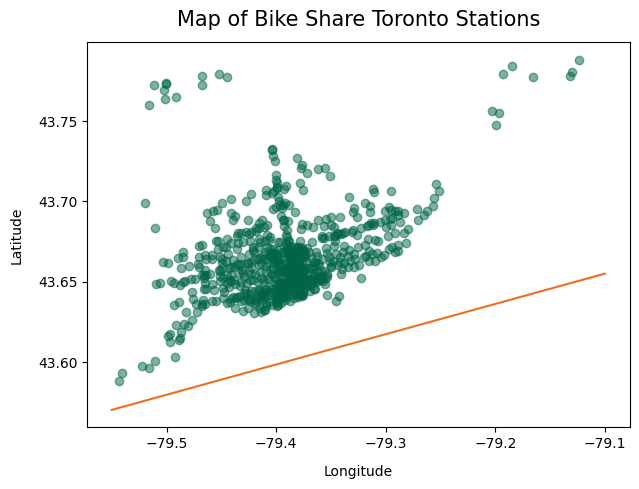

In [6]:
# Make a map to show the imaginary line in Lake Ontario parallel to Bloor/Danforth
plt.scatter(x=data['lon'], y=data['lat'], alpha=0.5)
plt.plot([-79.55,-79.1], [43.57, 43.655], color=c_2_hex)
plt.title('Map of Bike Share Toronto Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [7]:
# Function to find shortest shortest distance (in km) to line 
# More info: https://stackoverflow.com/questions/25707750/point-to-line-using-angles-and-haversine-with-3-lat-long-points
def distanceToLine(longitude, latitude):
    '''
    Input: lat/long of a Bike Share Toronto Station
    Output: shortest distance (in km) to an imaginary line in Lake Ontario parallel to Bloor/Danforth
    '''
    # Get lengths of each side of the triangle
    line_ab = haversine(-79.55, 43.57, -79.1, 43.655)
    line_bc = haversine(-79.1, 43.655, longitude, latitude)
    line_ac = haversine(-79.55, 43.57, longitude, latitude)

    # Get angle of left side of the triangle
    angle_bac = np.arccos((np.square(line_ac) + np.square(line_ab)
                           - np.square(line_bc))/(2 * line_ac * line_ab))
    
    # Return shortest distance to line (in km)
    return np.sin(angle_bac) * line_ac

In [8]:
# Make column for distance to imaginary line in Lake Ontario parallel to Bloor/Danforth
data['km_to_lake'] = distanceToLine(data['lon'], data['lat'])

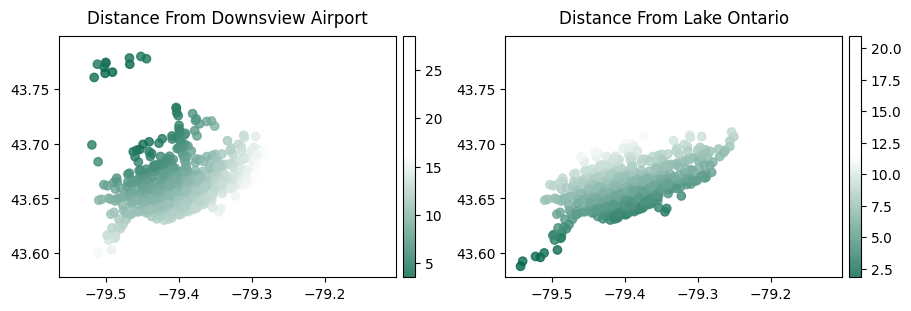

In [9]:
# Set plot style parameters
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.titlepad'] = 9
plt.rcParams['axes.labelpad'] = 5

# Initiate figure
fig_b, axs_b = plt.subplots(nrows=1, ncols=2, figsize=(9,3), layout="constrained",
                            gridspec_kw={'wspace': 0.03, 'hspace': 0.05})

# Create list of subplot info (in a manner that mimmicks "axs_b")
subplots_info = [
    ['Distance From Downsview Airport', data['km_to_da'], cmap_features],
    ['Distance From Lake Ontario', data['km_to_lake'], cmap_features]
    ]

# Make 2 maps to verify that the newly created columns describe what they proport to
for col in range(2):
    temp_ax = axs_b[col]
    temp_subplot = temp_ax.scatter(x=data['lon'], y=data['lat'], c=subplots_info[col][1],
        cmap=subplots_info[col][2], alpha=0.8)
    temp_ax.set_title(subplots_info[col][0])
    fig_b.colorbar(temp_subplot, ax=temp_ax, pad=0.02)

Text(0, 0.5, 'Latitude')

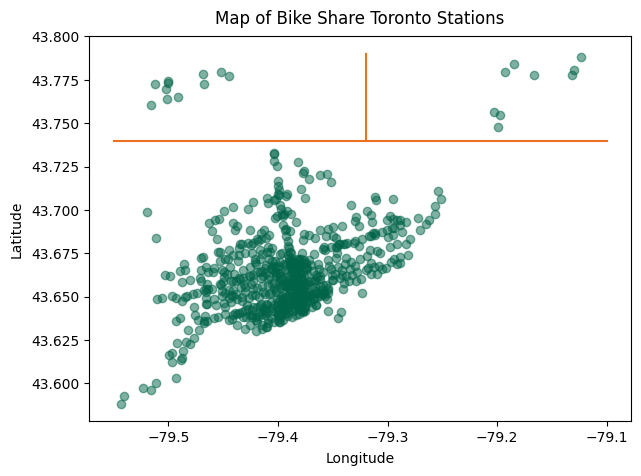

In [10]:
# Make a map to show the "cutoff" line. Stations in top-left will be categorized as "Vaughan", top right will be
# "Scarborough", and bottom will be "Toronto".
plt.scatter(x=data['lon'], y=data['lat'], alpha=0.5)
plt.plot([-79.55,-79.1], [43.74, 43.74], color=c_2_hex)
plt.plot([-79.32,-79.32], [43.74, 43.79], color=c_2_hex)

plt.title('Map of Bike Share Toronto Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [11]:
# Make column for "area" — start with default of "Toronto"
data['area'] = "Toronto"

In [12]:
# Change some station's area to "Vaughan"
data.loc[(data['lat'] > 43.74), "area"] = "Vaughan"

# Change some station's area to "Scarborough"
data.loc[(data['lat'] > 43.74) & (data['lon'] > -79.32), "area"] = "Scarborough"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


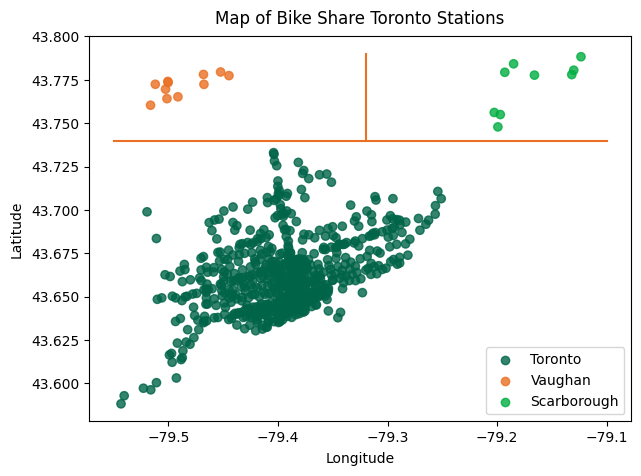

In [13]:
# Make a map to validate that categories were added correctly
# Side-Note: This looks like decision forest regression. That could be a good model to compare this to.
area_colors = {'Toronto': c_1_hex, 'Vaughan': c_2_hex, 'Scarborough': c_3_hex}

plt.scatter(x=data['lon'], y=data['lat'], alpha=0.8, c=data['area'].map(area_colors))
plt.plot([-79.55,-79.1], [43.74, 43.74], color=c_2_hex)
plt.plot([-79.32,-79.32], [43.74, 43.79], color=c_2_hex)

plt.title('Map of Bike Share Toronto Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title="Color", loc='lower right')

# Creating the legend
legend_labels = list(area_colors.keys())
legend_handles = [plt.scatter([], [], alpha=0.8, c=area_colors[label], label=label) for label in legend_labels]
plt.legend(handles=legend_handles, loc='lower right')

plt.show()

In [14]:
# Change categorical column "area" to binary columns
data = pd.concat([data, pd.get_dummies(data['area']).drop(columns='Toronto')], axis=1).drop(columns="area").rename(
    columns={'Vaughan': 'vaughan', 'Scarborough': 'scarborough'}
    )

data.head(3)

,station_id,end_ratio,lat,lon,elevation,km_to_da,km_to_lake,scarborough,vaughan
0,7000,0.495148,43.639832,-79.395954,83.367996,12.397185,4.357491,0,0
1,7001,0.500354,43.664964,-79.383550,107.094704,10.691659,6.808329,0,0
2,7002,0.495859,43.667333,-79.399429,114.094002,9.679037,7.386555,0,0


### 3. TEST LINEAR REGRESSION MODELS <a class="anchor" id="3"></a>

<Axes: >

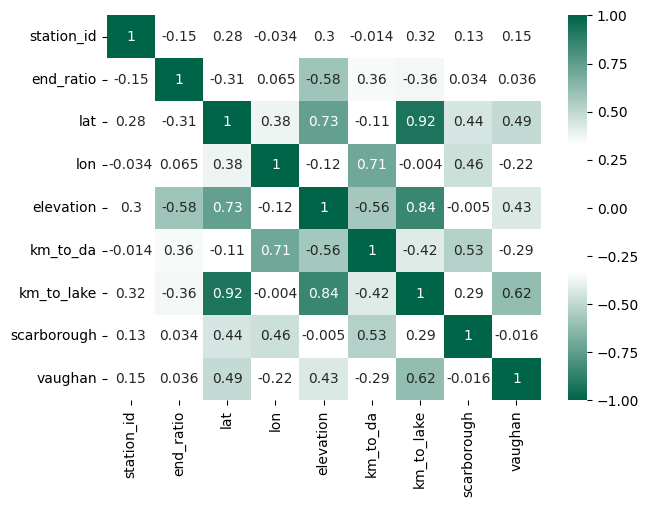

In [15]:
# Make correlation heatmap
sns.heatmap(data.corr(), annot=True, cmap=corr_cmap, vmin=-1.0, vmax=1.0)

Looking at the correlation heatmap above, it can be seen that km_to_lake is very highly correlated with both latitude and elevation. This means that the correlation coefficients and p-values corresponding to these 3 features will have no decipherable meaning. This is not a problem for the current model, however, because this model is only concerned with prediction. There is no goal of isolating the effects of the various features. There is no way to separate latitude/longitude from elevation or distance to Lake Ontario in the real world, so there is no reason to know how one of these 3 features would predict a station's ride-end ratio independently from the others.

In [16]:
# Separate data into train data and test data
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['station_id', 'end_ratio']),
                                                   data['end_ratio'], test_size=0.2,
                                                   random_state=88)

In [17]:
# Make a function to test linear regression or random forest regression models with varying features
def testRegression(input_X_train, input_y_train, input_title, input_linear):
    '''
    Input: train_X data, train_y data, model title (used for graph), Regression type (True = Linear, False = Random Forest)
    Output: plot (which is also saved to wd), mean RMSE, mean SD, mean r^2
    '''

    # Fit model to linear regression or random forest regression
    model = LinearRegression() if input_linear == True else RandomForestRegressor(n_estimators=100, random_state=99)
    model.fit(input_X_train, input_y_train)

    # Edit title, to include model type
    if input_linear == True:
        input_title = "Linear Regression " + input_title
    else:
        input_title = "Random Forest Regression " + input_title

    # Use model to get predictions of y_train
    y_hat = model.predict(input_X_train)

    # Plot ride-end ratio preditions vs. actual values
    plt.rcParams['figure.figsize'] = 5, 4
    plt.scatter(input_y_train, y_hat, alpha=0.5)
    plt.plot(np.linspace(-5,5,100), np.linspace(-5,5,100), color=c_3_hex, label='y=2x+1')
    plt.xlim(min(min(input_y_train),min(y_hat)) - 0.04, max(max(input_y_train),max(y_hat)) + 0.04)
    plt.ylim(min(min(input_y_train),min(y_hat)) - 0.04, max(max(input_y_train),max(y_hat)) + 0.04)
    plt.xlabel("Actual Data Ride-End Ratio")
    plt.ylabel("Predicted Ride-End Ratio")
    plt.title(input_title)
    plt.savefig("{}.png".format(input_title))
    plt.show()

    model = LinearRegression() if input_linear == True else RandomForestRegressor(n_estimators=100, random_state=99)

    # Cross-validation score (RMSE)
    mse_scores = cross_val_score(
            model, 
            input_X_train,
            input_y_train,
            cv=5,
            scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-mse_scores)

    # Cross-validation score (r2)
    r2_scores = cross_val_score(
            model, 
            input_X_train,
            input_y_train,
            cv=4,
            scoring="r2"
    )

    # output all
    print("The average RMSE from the 4-fold cross-validation is " + str(round(rmse_scores.mean(), 4)) + ".")
    print("RMSE scores: " + str(rmse_scores) +"\n")
    print("The average r^2 from the 4-fold cross-validation is " + str(round(r2_scores.mean(), 4)) + ".")
    print("r^2 scores: " + str(r2_scores))



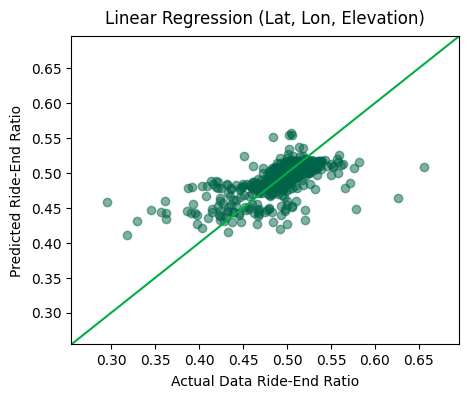

The average RMSE from the 4-fold cross-validation is 0.03.
RMSE scores: [0.0260218  0.03047495 0.0346686  0.02924236 0.02956283]

The average r^2 from the 4-fold cross-validation is 0.3801.
r^2 scores: [0.5249123  0.32891391 0.29866129 0.3680107 ]


In [18]:
# Test base model with linear regression (features: lat, lon, elevation)
testRegression(X_train[['lat', 'lon', 'elevation']], y_train, "(Lat, Lon, Elevation)", True)

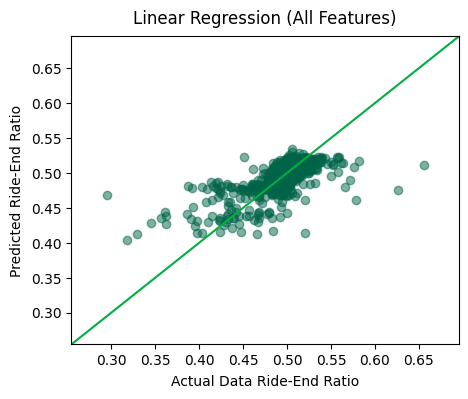

The average RMSE from the 4-fold cross-validation is 0.029.
RMSE scores: [0.02402542 0.0342612  0.03249347 0.02680196 0.02718412]

The average r^2 from the 4-fold cross-validation is 0.4107.
r^2 scores: [0.5863841  0.20465405 0.37868095 0.4732447 ]


In [19]:
# Test complete model (all features)
testRegression(X_train, y_train, "(All Features)", True)

The second version of the linear regression model (the "all features" model) recieved slightly better scores during testing, but both models performed similarly in their prediction ability.

### 4. TEST RANDOM FOREST REGRESSION MODELS <a class="anchor" id="4"></a>

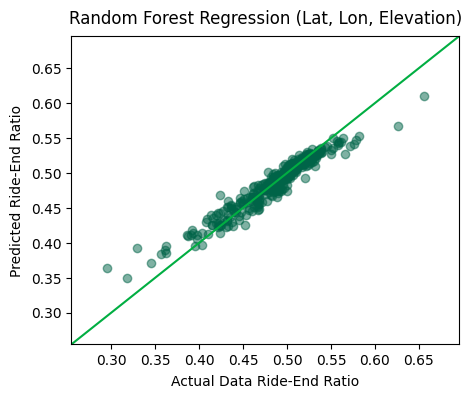

The average RMSE from the 4-fold cross-validation is 0.0298.
RMSE scores: [0.02741683 0.03552798 0.03120259 0.02977578 0.02526503]

The average r^2 from the 4-fold cross-validation is 0.4083.
r^2 scores: [0.50212297 0.27862082 0.30083809 0.55178778]


In [20]:
# Test base model with random forest regression (features: lat, lon, elevation)
testRegression(X_train[['lat', 'lon', 'elevation']], y_train, "(Lat, Lon, Elevation)", False)

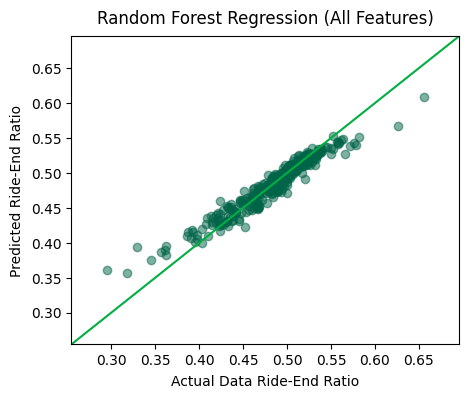

The average RMSE from the 4-fold cross-validation is 0.0303.
RMSE scores: [0.02757559 0.03632453 0.03190306 0.03015947 0.02539352]

The average r^2 from the 4-fold cross-validation is 0.4143.
r^2 scores: [0.51837719 0.28366246 0.30223086 0.55275544]


In [21]:
# Test complete model with random forest regression (all features)
testRegression(X_train, y_train, "(All Features)", False)

The linear regression and random forest regression models produced similar RMSE and r^2 scores. This outcome is due to the nature of the data. Since the vast majority of data points are located around the mean, the relatively few data points with high residuals in the linear regression model do not have much of an effect on RMSE. The concentration of data points around the mean also explains why the models have such low r^2 values. r^2 measures a model's predictive ability versus a base model of the mean, and in the case of this data set, the mean is actually quite a good predictor. For these reasons, the visualization is the best way to compare the models. Looking at the vizualizations, it can be seen that the random forest regression model is providing more accurate predictions.

Since both random forest regression models performed similarly well, the simpler model will be chosen as the best model.

<Axes: xlabel='end_ratio', ylabel='Count'>

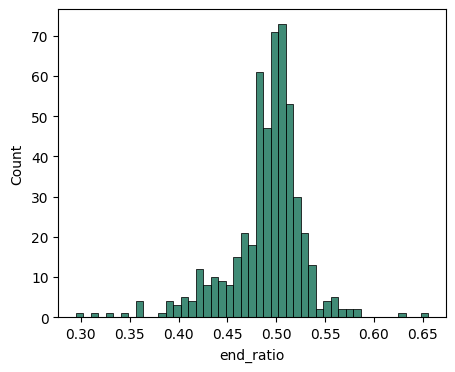

In [22]:
# Histogram of y_train ride-end ratio data
sns.histplot(y_train)

### 5. MAKE AND SAVE FINAL MODEL <a class="anchor" id="5"></a>

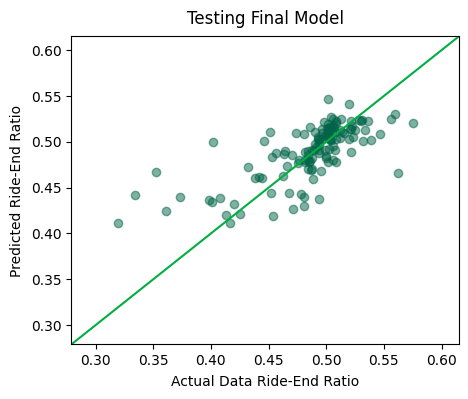

In [33]:
# Final test of chosen model (model: random forest regression, features: lat, lon, elevation)
final_test_model = RandomForestRegressor(n_estimators=100, random_state=55)
final_test_model.fit(X_train[['lat', 'lon', 'elevation']], y_train)
final_test_y_hat = final_test_model.predict(X_test[['lat', 'lon', 'elevation']])

# Plot ride-end ratio preditions vs. actual values
plt.rcParams['figure.figsize'] = 5, 4
plt.scatter(y_test, final_test_y_hat, alpha=0.5)
plt.plot(np.linspace(-5,5,100), np.linspace(-5,5,100), color=c_3_hex, label='y=2x+1')
plt.xlim(min(min(y_test),min(final_test_y_hat)) - 0.04, max(max(y_test),max(final_test_y_hat)) + 0.04)
plt.ylim(min(min(y_test),min(final_test_y_hat)) - 0.04, max(max(y_test),max(final_test_y_hat)) + 0.04)
plt.xlabel("Actual Data Ride-End Ratio")
plt.ylabel("Predicted Ride-End Ratio")
plt.title("Testing Final Model")
plt.show()

In [34]:
# Isolate final X and y data
X_final = data[['lat', 'lon', 'elevation']]
y_final = data['end_ratio']

# Fit model
final_model = RandomForestRegressor(n_estimators=100, random_state=55)
final_model.fit(X_final, y_final)

# Save model
joblib.dump(final_model, "ride_end_ratio_model.pkl")

['ride_end_ratio_model.pkl']